# Testing classifier accuracy as the lowest abundance peptides are incrementally removed from the training set. (Fig5)

In [242]:
import Classification_Utils as cu
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [257]:
BINARY = True

## Load and combine data from all tissues

In [244]:
df = pd.read_csv('FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(68623, 253)


## Map each column to a corresponding label

In [245]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [246]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

## Make train-test split

In [247]:
train_df, test_df, train_labels, test_labels = train_test_split(
    df.T, labels, test_size=0.30,# 30% of the data held out in test set
    random_state=0,    # Setting random_state ensures the same train/test split occurs each time this is run
    stratify=labels)   # Maintain relative ratio of samples from each tissue

## Transform Train Data by Reducing Peptides

In [248]:
"""
Transforms a dataframe by filtering out the lowest abundance peptides in each tissue.

Args:
    df (dataframe): rows are datasets and columns are peptides
    tissues (list of strings): list of tissues represented in df
    percentile(float): percentile of peptides to keep from each tissue
    impute_val (float): value to fill missing values with
    
Returns:
    df transformed so that only the specified percentile of peptides with the highest mean abundance values in each tissue are kept
"""
def keep_percentile_peptides(df, tissues, percentile, impute_val):
    
    df = df.T
    tissue_dfs = []
    
    for tissue in tissues:
        cols_to_drop = [col for col in df.columns.values if not col.startswith(tissue)]
        tissue_df = df.drop(cols_to_drop, axis=1)
        
        ### Drop rows with nothing observed
        tissue_df.replace(impute_val, np.nan, inplace=True)
        tissue_df.dropna(axis=0, how='all', inplace=True)
        tissue_df.replace(np.nan, impute_val, inplace=True)
        
        peptide_mean_abundances = tissue_df.mean(axis=1) # pandas series

        # sort by average abundance value, drop below threshold
        peptide_mean_abundances.sort_values(ascending=False, inplace=True)
        num_peptides_to_keep = math.ceil(len(peptide_mean_abundances) * percentile/100)
        peptides_to_drop = peptide_mean_abundances[num_peptides_to_keep:].index.values
        
        print(tissue_df.shape[0], len(peptides_to_drop))
        
        tissue_df.drop(peptides_to_drop, axis=0, inplace=True)
        
        tissue_dfs.append(tissue_df)
        
    # join dataframes
    combined_df = pd.DataFrame()
    for next_df in tissue_dfs:
        combined_df = combined_df.join(next_df, how='outer')
    
    combined_df.replace(np.nan, impute_val, inplace=True)
        
    return combined_df.T

In [249]:
imputed_val = train_df.mode().iloc[0, 0]

percentile_to_keep = 100

print('Original train_df dimensions:', train_df.shape)
train_df = keep_percentile_peptides(train_df, tissues, percentile_to_keep, imputed_val)
print('Reduced train_df dimensions:', train_df.shape)

features_to_keep = train_df.columns.values.tolist()

column_names = train_df.index.values.tolist()
train_labels = cu.get_labels(column_names, tissues_to_columns)

Original train_df dimensions: (177, 68623)
7756 0
5015 0
1863 0
24555 0
17951 0
38793 0
13159 0
29372 0
8948 0
Reduced train_df dimensions: (177, 68609)


## Train classifiers on the reduced data

In [250]:
if BINARY:
    train_df = cu.abundance_to_binary(train_df)
    min_max_train_df = train_df
else:
    std_scaler = StandardScaler()
    train_df = std_scaler.fit_transform(train_df)

    min_max_scaler = MinMaxScaler()
    min_max_train_df = min_max_scaler.fit_transform(train_df)

In [251]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

lr = LogisticRegression(random_state=0)
mnb = MultinomialNB()
rf = RandomForestClassifier(random_state=0)
svc = SVC(kernel='linear', random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
gnb = GaussianNB()
knn = KNeighborsClassifier()

models = [lr, mnb, rf, svc, gbc, gnb, knn]

model_names = ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest', 'SVC', 
               'Gradient Boosting', 'Gaussian Naive Bayes', 'K-Nearest Neighbors']

for model in models:
    if isinstance(model, MultinomialNB):
        model.fit(min_max_train_df, train_labels)
    else:
        model.fit(train_df, train_labels)

## Classify Training Set

In [252]:
# Test data features (peptides) must match training data features exactly
# So we only keep the peptides still present in the training data after peptide reduction
print(test_df.shape)
test_df = test_df[features_to_keep]
print(test_df.shape)

(76, 68623)
(76, 68609)


In [253]:
if BINARY:
    test_df = cu.abundance_to_binary(test_df)
    min_max_test_df = test_df
else:
    test_df = std_scaler.fit_transform(test_df)
    min_max_test_df = min_max_scaler.fit_transform(test_df)

### Use models to predict new data
* Results used to plot Fig5

In [254]:
lr_pred = lr.predict(test_df)
lr_result = lr.score(test_df, test_labels)

mnb_pred = mnb.predict(min_max_test_df)
mnb_result = mnb.score(min_max_test_df, test_labels)

rf_pred = rf.predict(test_df)
rf_result = rf.score(test_df, test_labels)

svc_pred = svc.predict(test_df)
svc_result = svc.score(test_df, test_labels)

knn_pred = knn.predict(test_df)
knn_result = knn.score(test_df, test_labels)

gnb_pred = gnb.predict(test_df)
gnb_result = gnb.score(test_df, test_labels)

gbc_pred = gbc.predict(test_df)
gbc_result = gbc.score(test_df, test_labels)

In [255]:
print(svc_result)
print(knn_result)
print(gnb_result)
print(gbc_result)
print(mnb_result)
print(lr_result)
print(rf_result)

1.0
0.973684210526
1.0
1.0
0.986842105263
1.0
1.0


Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 8 0 0 1]
 [0 0 0 0 0 0 8 0 1]
 [0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 9]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.89  0.    0.    0.11]
 [ 0.    0.    0.    0.    0.    0.    0.89  0.    0.11]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]


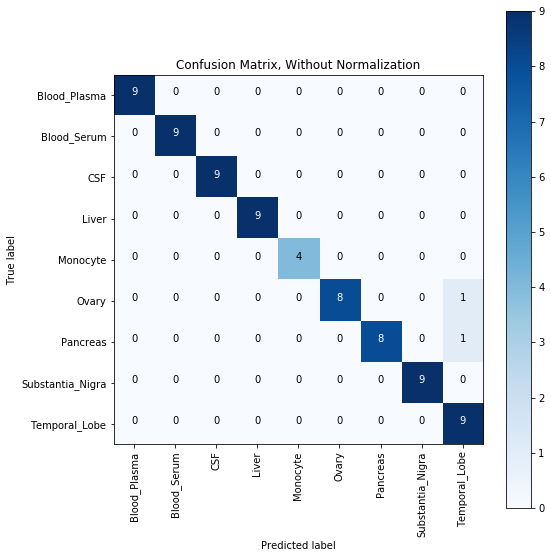

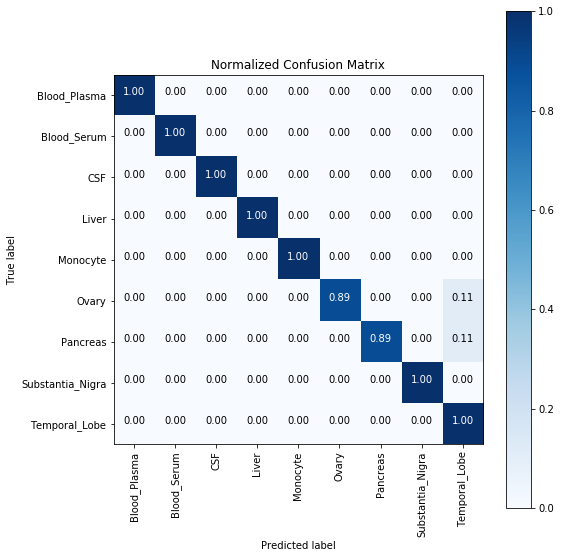

In [256]:
cu.show_confusion_matrices(test_labels, knn_pred, tissues)